In [1]:
from sklearn.metrics import root_mean_squared_error
import seaborn as sns
import pandas as pd
import time

from auxfunctions import *
from implementations import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
def rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12):
    return (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)

def gen_centers(X_test, n_clusters, d=2):
    if X_test.shape[0] >= n_clusters:
        KM = KMeans(n_clusters=n_clusters).fit(X_test)
        return KM.cluster_centers_
    else:
        return np.vstack([X_test, np.random.uniform(0,1,(n_clusters-X_test.shape[0],d))])

In [3]:
d = 3
sup = 1

n = 5_000
n_test = 100

# $\nu_{1} = \nu_{2} = 1/2$

In [4]:
nu_1 = 1/2
nu_2 = 1/2

## $\theta_{1} = 2$, $\theta_{2} = 2.5$

In [5]:
theta_1 = 2
theta_2 = 2.5

In [6]:
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

0.7155417527999329

In [7]:
Ks = [
#   K,     # N
    5,     # 1_000
    10,    # 500
    50,    # 100
    500,   # 10
    1_000, # 5
]

Ns = [n // K for K in Ks]

aux = [] # METHOD, N, K, TIME, RMSE
num_replications = 50

In [8]:
for _ in range(num_replications):
    start = time.time()

    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]
    sigma = sigma[n_test:, :][:, n_test:]

    for N, n_clusters in zip(Ns, Ks):
        # coKNN
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()
        aux.append(['coKNN', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM
        A_1, A_2 = gen_As(X_1, X_2, n_clusters)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK KM', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM+
        centers = gen_centers(X_test, n_clusters, d)
        A_1, A_2 = gen_As(X_1, X_2, n_clusters, centers)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK KM+', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    # CO KRIGING
    start_time = time.time()
    Y_pred = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)
    end_time = time.time()
    aux.append(['coK', n, 1, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    end = time.time()
    print(f'{_}: {(end-start)//60:.0f}min {(end-start)%60:.0f}s')

0: 16min 19s
1: 12min 31s
2: 11min 40s
3: 11min 43s
4: 11min 42s
5: 11min 39s
6: 11min 45s
7: 11min 45s
8: 11min 42s
9: 11min 39s
10: 11min 39s
11: 11min 41s
12: 11min 43s
13: 11min 38s
14: 11min 38s
15: 11min 40s
16: 11min 36s
17: 11min 42s
18: 11min 41s
19: 11min 44s
20: 11min 43s
21: 11min 52s
22: 11min 43s
23: 11min 38s
24: 11min 44s
25: 11min 36s
26: 11min 41s
27: 11min 44s
28: 11min 43s
29: 11min 44s
30: 11min 52s
31: 11min 41s
32: 11min 39s
33: 11min 37s
34: 11min 39s
35: 12min 3s
36: 11min 41s
37: 11min 39s
38: 11min 42s
39: 11min 41s
40: 12min 3s
41: 11min 51s
42: 11min 43s
43: 11min 38s
44: 11min 36s
45: 11min 36s
46: 11min 40s
47: 11min 37s
48: 11min 37s
49: 11min 31s


In [9]:
aux = pd.DataFrame(aux, columns=['METHOD', 'N', 'K', 'TIME', 'RMSE'])

aux['n'] = n
aux['nu_1'] = nu_1
aux['nu_2'] = nu_2
aux['theta_1'] = theta_1
aux['theta_2'] = theta_2

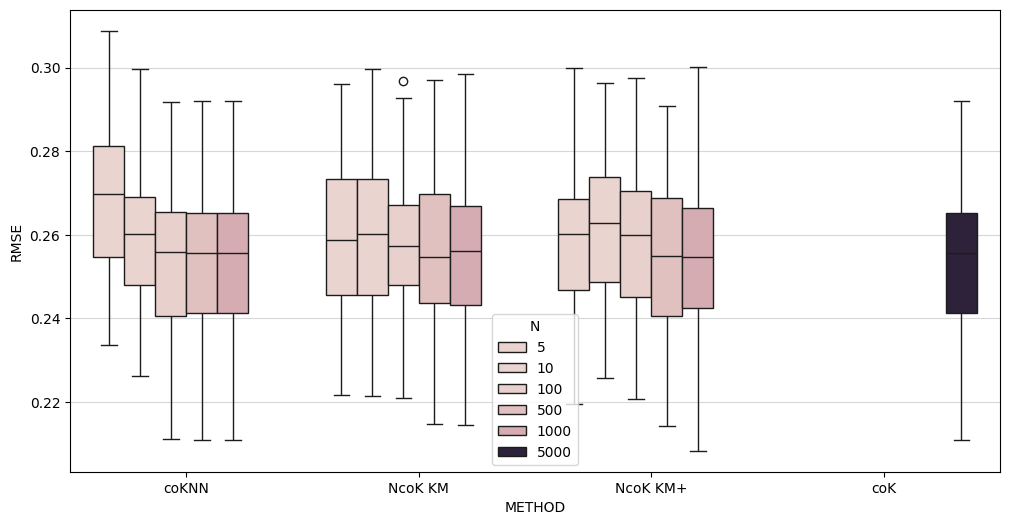

In [10]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='METHOD', y='RMSE', hue='N')
plt.grid(axis='y', alpha=0.5, zorder=1);

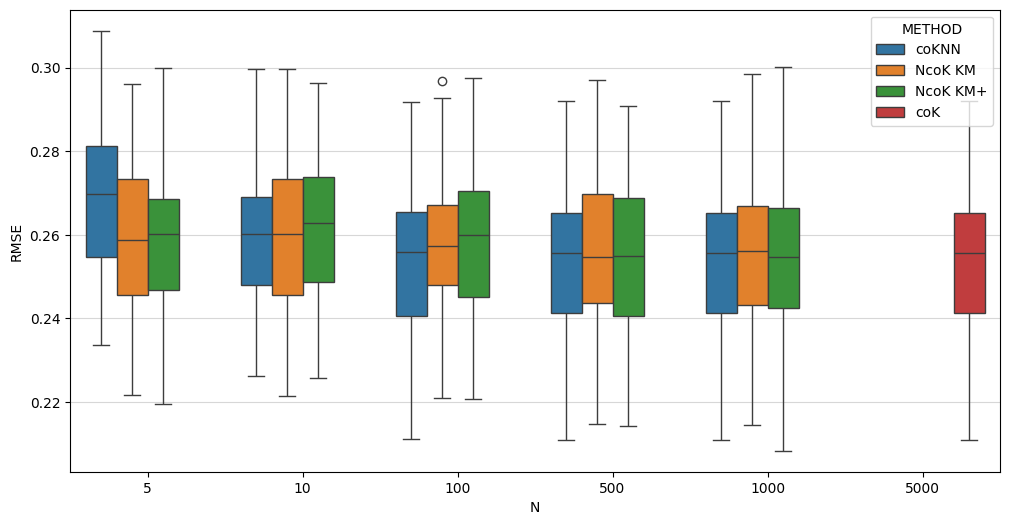

In [11]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='N', y='RMSE', hue='METHOD')
plt.grid(axis='y', alpha=0.5, zorder=1);

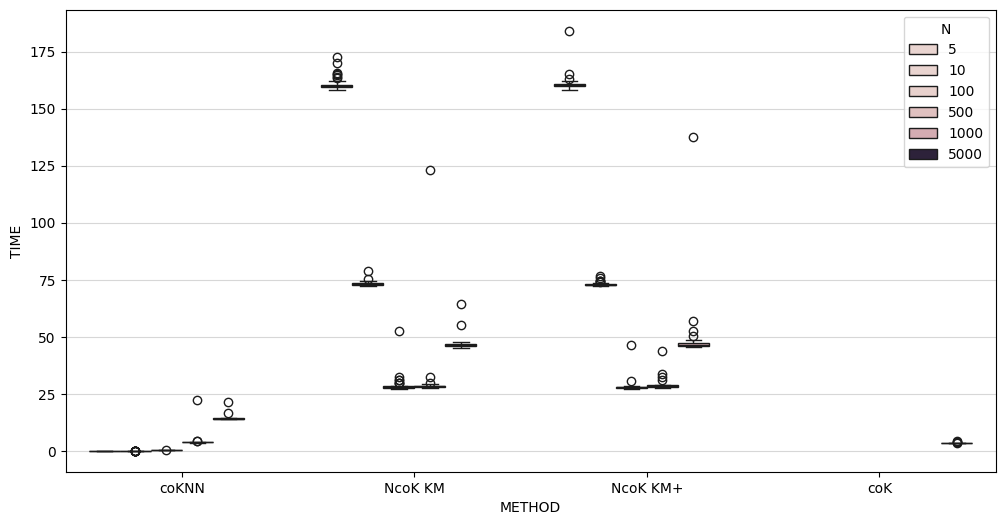

In [12]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='METHOD', y='TIME', hue='N')
plt.grid(axis='y', alpha=0.5, zorder=1);

In [38]:
data = pd.read_csv('results_experiments_d_3.csv', sep=';')
data.head()

,METHOD,N,K,TIME,RMSE,n,nu_1,nu_2,theta_1,theta_2
0,coKNN,1000,5,21.629719,0.270550,5000.0,0.5,0.5,2.0,2.5
1,NcoK KM,1000,5,64.293552,0.273641,5000.0,0.5,0.5,2.0,2.5
2,NcoK KM+,1000,5,137.734451,0.276366,5000.0,0.5,0.5,2.0,2.5
3,coKNN,500,10,22.283544,0.270611,5000.0,0.5,0.5,2.0,2.5
4,NcoK KM,500,10,123.049370,0.272795,5000.0,0.5,0.5,2.0,2.5


In [14]:
data = pd.concat([aux, data], axis=0)

In [15]:
data.to_csv('results_experiments_d_3.csv', index=False, sep=';')

## $\theta_{1} = 4$, $\theta_{2} = 5$

In [5]:
theta_1 = 4
theta_2 = 5

In [6]:
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

0.7155417527999329

In [7]:
Ks = [
#   K,     # N
    5,     # 1_000
    10,    # 500
    50,    # 100
    500,   # 10
    1_000, # 5
]

Ns = [n // K for K in Ks]

aux = [] # METHOD, N, K, TIME, RMSE
num_replications = 50

In [8]:
for _ in range(num_replications):
    start = time.time()

    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]
    sigma = sigma[n_test:, :][:, n_test:]

    for N, n_clusters in zip(Ns, Ks):
        # coKNN
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()
        aux.append(['coKNN', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM
        A_1, A_2 = gen_As(X_1, X_2, n_clusters)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK KM', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM+
        centers = gen_centers(X_test, n_clusters, d)
        A_1, A_2 = gen_As(X_1, X_2, n_clusters, centers)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK KM+', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    # CO KRIGING
    start_time = time.time()
    Y_pred = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)
    end_time = time.time()
    aux.append(['coK', n, 1, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    end = time.time()
    print(f'{_}: {(end-start)//60:.0f}min {(end-start)%60:.0f}s')

0: 12min 22s
1: 12min 8s
2: 12min 11s
3: 12min 8s
4: 12min 13s
5: 12min 11s
6: 12min 4s
7: 12min 9s
8: 12min 7s
9: 12min 14s
10: 12min 17s
11: 12min 5s
12: 12min 10s
13: 12min 6s
14: 12min 12s
15: 12min 10s
16: 12min 5s
17: 12min 47s
18: 12min 8s
19: 12min 12s
20: 12min 12s
21: 12min 12s
22: 12min 15s
23: 12min 8s
24: 12min 8s
25: 12min 5s
26: 12min 4s
27: 12min 15s
28: 12min 14s
29: 12min 13s
30: 12min 8s
31: 12min 21s
32: 12min 5s
33: 12min 4s
34: 12min 11s
35: 12min 4s
36: 12min 2s
37: 12min 7s
38: 12min 21s
39: 12min 6s
40: 12min 6s
41: 12min 7s
42: 12min 48s
43: 12min 6s
44: 12min 11s
45: 12min 8s
46: 12min 7s
47: 12min 6s
48: 12min 12s
49: 12min 13s


In [9]:
aux = pd.DataFrame(aux, columns=['METHOD', 'N', 'K', 'TIME', 'RMSE'])

aux['n'] = n
aux['nu_1'] = nu_1
aux['nu_2'] = nu_2
aux['theta_1'] = theta_1
aux['theta_2'] = theta_2

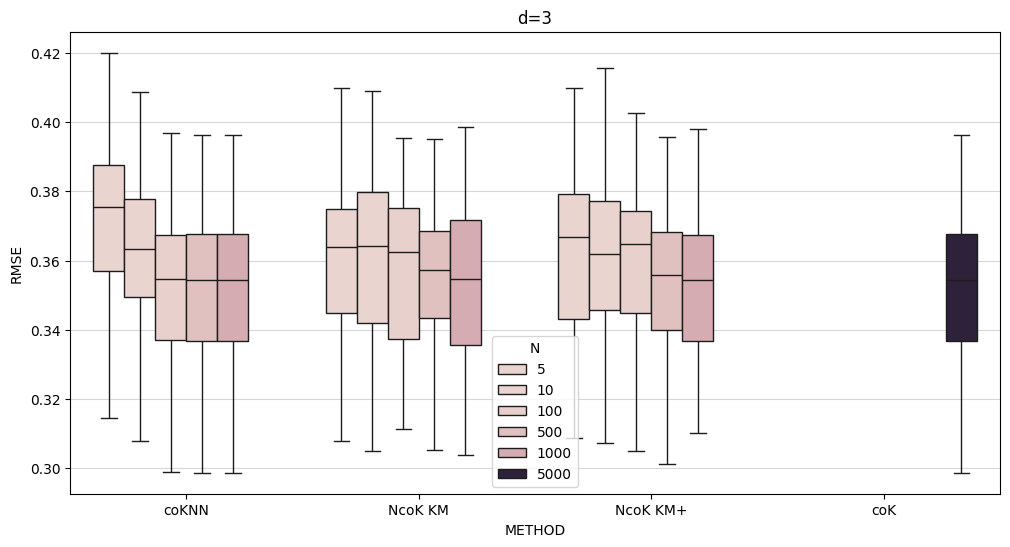

In [10]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='METHOD', y='RMSE', hue='N')
plt.title(f'{d=}')
plt.grid(axis='y', alpha=0.5, zorder=1);

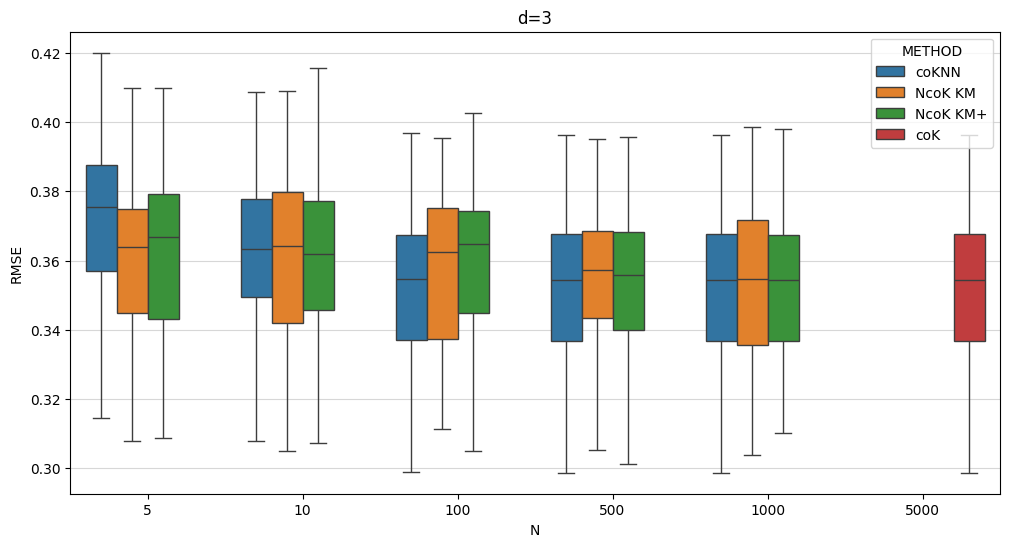

In [11]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='N', y='RMSE', hue='METHOD')
plt.title(f'{d=}')
plt.grid(axis='y', alpha=0.5, zorder=1);

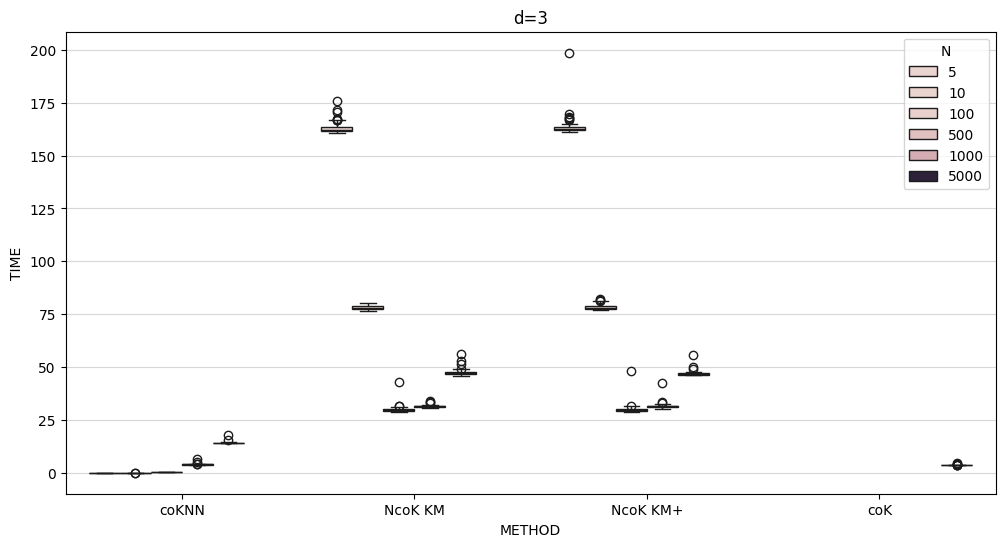

In [12]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='METHOD', y='TIME', hue='N')
plt.title(f'{d=}')
plt.grid(axis='y', alpha=0.5, zorder=1);

In [13]:
data = pd.read_csv('results_experiments_d_3.csv', sep=';')
data = pd.concat([data, aux], axis=0)
data.to_csv('results_experiments_d_3.csv', index=False, sep=';')

# $\theta_1 = 4$, $\theta_2 = 5$

In [40]:
theta_1 = 4
theta_2 = 5

## $\nu_{1} = 1/2, \nu_{2} = 5/2$

In [41]:
nu_1 = 1/2
nu_2 = 5/2

In [42]:
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

0.5059644256269408

In [43]:
Ks = [
#   K,     # N
    5,     # 1_000
    10,    # 500
    50,    # 100
    500,   # 10
    1_000, # 5
]

Ns = [n // K for K in Ks]

aux = [] # METHOD, N, K, TIME, RMSE
num_replications = 50

In [44]:
for _ in range(num_replications):
    start = time.time()

    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]
    sigma = sigma[n_test:, :][:, n_test:]

    for N, n_clusters in zip(Ns, Ks):
        # coKNN
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()
        aux.append(['coKNN', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM
        A_1, A_2 = gen_As(X_1, X_2, n_clusters)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK KM', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM+
        centers = gen_centers(X_test, n_clusters, d)
        A_1, A_2 = gen_As(X_1, X_2, n_clusters, centers)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK KM+', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    # CO KRIGING
    start_time = time.time()
    Y_pred = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)
    end_time = time.time()
    aux.append(['coK', n, 1, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    end = time.time()
    print(f'{_}: {(end-start)//60:.0f}min {(end-start)%60:.0f}s')

0: 12min 28s
1: 12min 14s
2: 12min 13s
3: 12min 17s
4: 12min 17s
5: 12min 19s
6: 12min 19s
7: 12min 20s
8: 12min 16s
9: 12min 17s
10: 12min 16s
11: 12min 18s
12: 12min 21s
13: 12min 12s
14: 12min 22s
15: 12min 18s
16: 12min 20s
17: 12min 27s
18: 12min 23s
19: 12min 18s
20: 12min 23s
21: 12min 30s
22: 12min 18s
23: 12min 21s
24: 12min 23s
25: 12min 21s
26: 12min 21s
27: 12min 27s
28: 12min 24s
29: 12min 24s
30: 12min 21s
31: 12min 44s
32: 12min 28s
33: 12min 37s
34: 12min 28s
35: 12min 27s
36: 12min 26s
37: 12min 35s
38: 12min 41s
39: 13min 56s
40: 14min 17s
41: 14min 46s
42: 14min 27s
43: 14min 14s
44: 14min 33s
45: 14min 32s
46: 14min 34s
47: 14min 40s
48: 14min 54s
49: 16min 27s


In [45]:
aux = pd.DataFrame(aux, columns=['METHOD', 'N', 'K', 'TIME', 'RMSE'])

aux['n'] = n
aux['nu_1'] = nu_1
aux['nu_2'] = nu_2
aux['theta_1'] = theta_1
aux['theta_2'] = theta_2

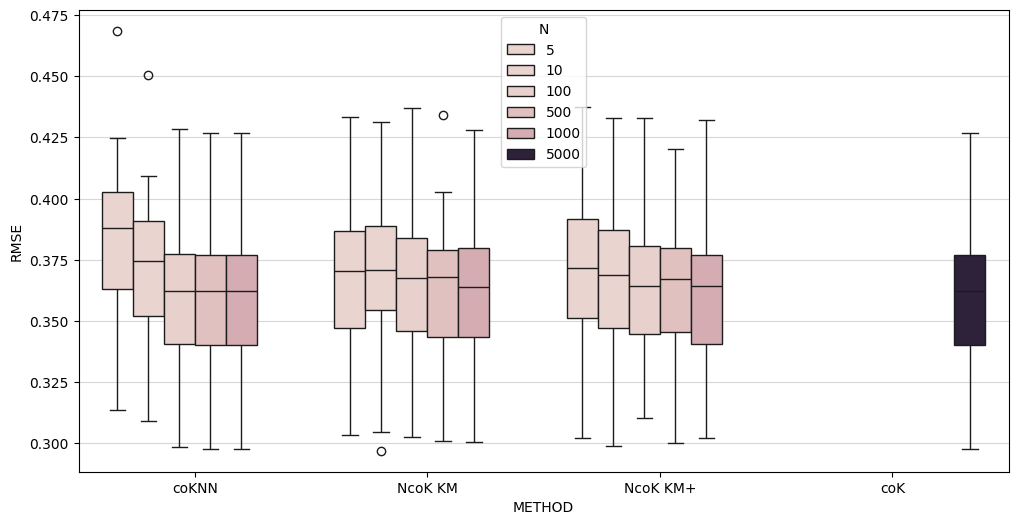

In [46]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='METHOD', y='RMSE', hue='N')
plt.grid(axis='y', alpha=0.5, zorder=1);

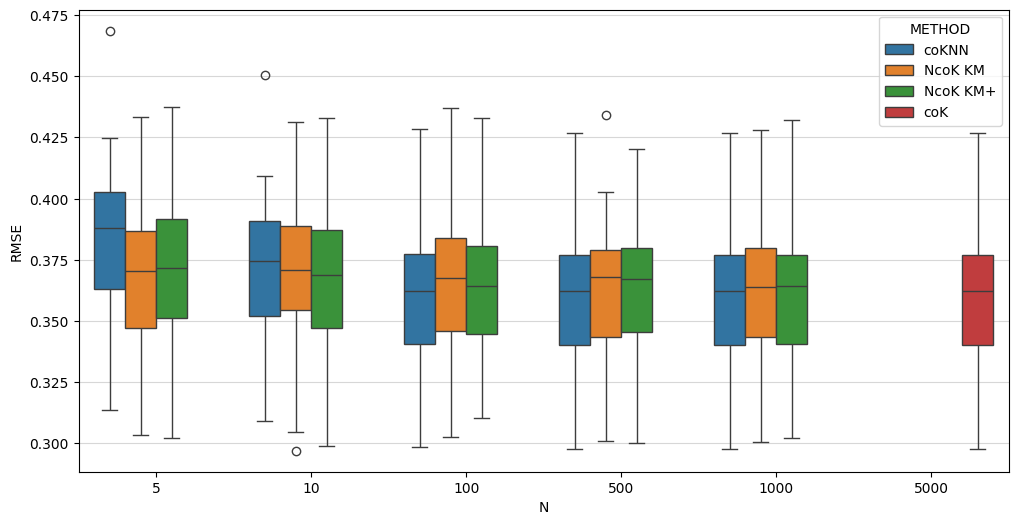

In [47]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='N', y='RMSE', hue='METHOD')
plt.grid(axis='y', alpha=0.5, zorder=1);

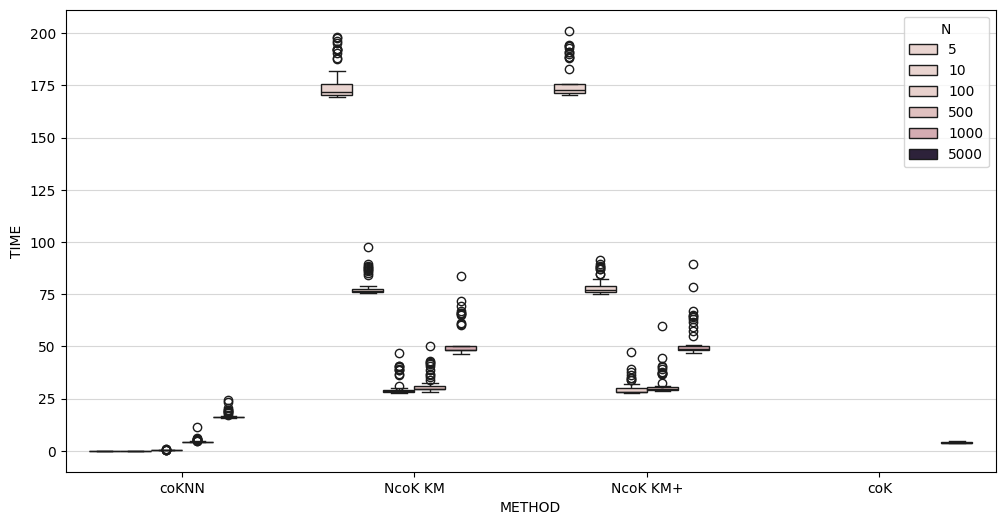

In [48]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='METHOD', y='TIME', hue='N')
plt.grid(axis='y', alpha=0.5, zorder=1);

In [49]:
data = pd.read_csv('results_experiments_d_3.csv', sep=';')
data.head()

,METHOD,N,K,TIME,RMSE,n,nu_1,nu_2,theta_1,theta_2
0,coKNN,1000,5,30.082545,0.331394,NaN,NaN,NaN,NaN,NaN
1,NcoK KM,1000,5,141.780833,0.336332,NaN,NaN,NaN,NaN,NaN
2,NcoK KM+,1000,5,49.674062,0.329246,NaN,NaN,NaN,NaN,NaN
3,coKNN,500,10,3.845571,0.331375,NaN,NaN,NaN,NaN,NaN
4,NcoK KM,500,10,28.882469,0.334277,NaN,NaN,NaN,NaN,NaN


In [50]:
data = pd.concat([data, aux], axis=0)

In [51]:
data.to_csv('results_experiments_d_3.csv', index=False, sep=';')

## $\nu_{1} = 5/2, \nu_{2} = 1/2$

In [17]:
nu_1 = 5/2
nu_2 = 1/2

In [18]:
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

0.5059644256269408

In [19]:
Ks = [
#   K,     # N
    5,     # 1_000
    10,    # 500
    50,    # 100
    500,   # 10
    1_000, # 5
]

Ns = [n // K for K in Ks]

aux = [] # METHOD, N, K, TIME, RMSE
num_replications = 50

In [21]:
for _ in range(num_replications):
    start = time.time()

    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]
    sigma = sigma[n_test:, :][:, n_test:]

    for N, n_clusters in zip(Ns, Ks):
        # coKNN
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()
        aux.append(['coKNN', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM
        A_1, A_2 = gen_As(X_1, X_2, n_clusters)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK KM', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM+
        centers = gen_centers(X_test, n_clusters, d)
        A_1, A_2 = gen_As(X_1, X_2, n_clusters, centers)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK KM+', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    # CO KRIGING
    start_time = time.time()
    Y_pred = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)
    end_time = time.time()
    aux.append(['coK', n, 1, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    end = time.time()
    print(f'{_}: {(end-start)//60:.0f}min {(end-start)%60:.0f}s')

0: 12min 37s
1: 12min 16s
2: 12min 16s
3: 12min 17s
4: 12min 10s
5: 12min 14s
6: 12min 21s
7: 12min 14s
8: 12min 11s
9: 12min 11s
10: 12min 8s
11: 12min 13s
12: 12min 15s
13: 12min 13s
14: 12min 11s
15: 12min 9s
16: 12min 14s
17: 12min 14s
18: 12min 10s
19: 12min 8s
20: 12min 12s
21: 12min 18s
22: 12min 12s
23: 12min 11s
24: 12min 13s
25: 12min 7s
26: 12min 11s
27: 12min 13s
28: 12min 13s
29: 12min 13s
30: 12min 13s
31: 12min 13s
32: 12min 10s
33: 12min 11s
34: 12min 8s
35: 12min 13s
36: 12min 17s
37: 12min 13s
38: 12min 11s
39: 12min 11s
40: 12min 10s
41: 12min 12s
42: 12min 10s
43: 12min 15s
44: 12min 14s
45: 12min 14s
46: 12min 14s
47: 12min 14s
48: 12min 11s
49: 12min 33s


In [22]:
aux = pd.DataFrame(aux, columns=['METHOD', 'N', 'K', 'TIME', 'RMSE'])

aux['n'] = n
aux['nu_1'] = nu_1
aux['nu_2'] = nu_2
aux['theta_1'] = theta_1
aux['theta_2'] = theta_2

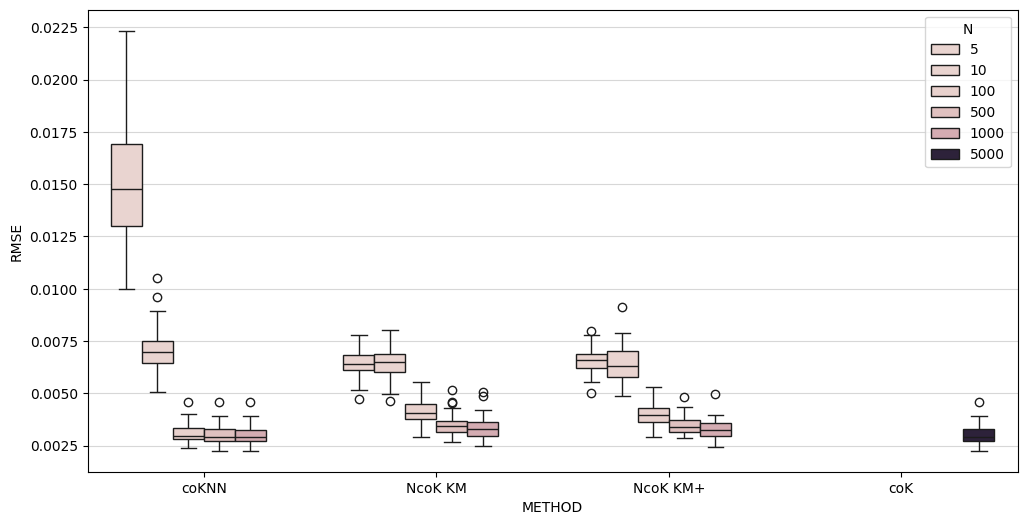

In [23]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='METHOD', y='RMSE', hue='N')
plt.grid(axis='y', alpha=0.5, zorder=1);

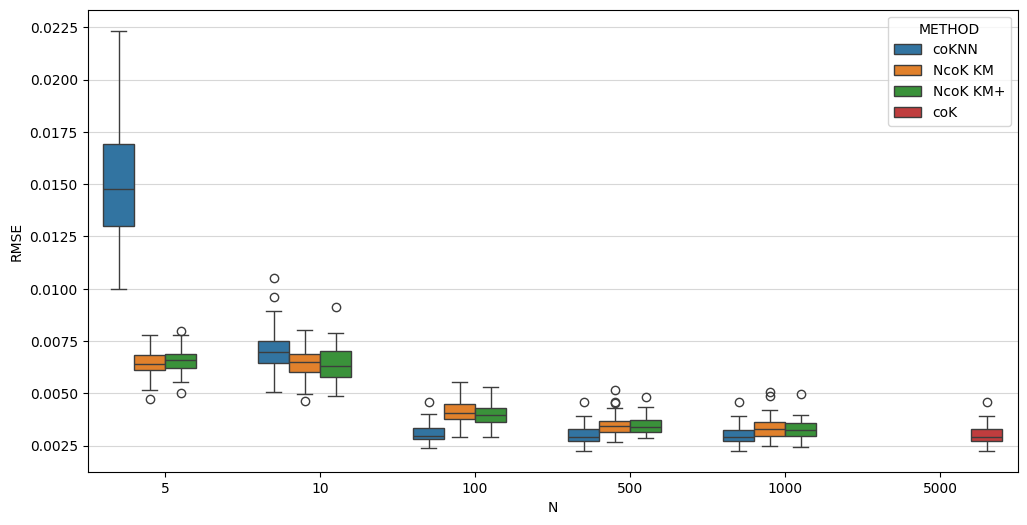

In [24]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='N', y='RMSE', hue='METHOD')
plt.grid(axis='y', alpha=0.5, zorder=1);

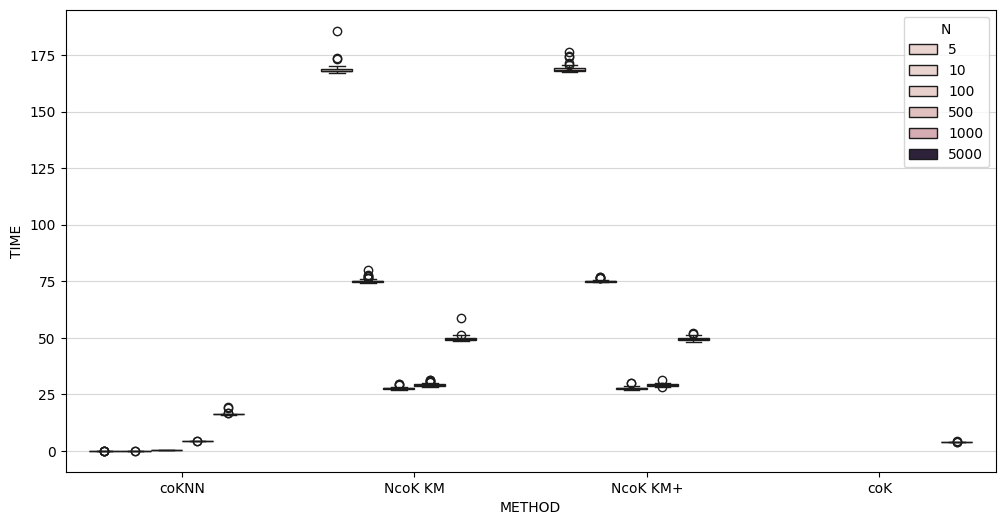

In [25]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='METHOD', y='TIME', hue='N')
plt.grid(axis='y', alpha=0.5, zorder=1);

In [26]:
data = pd.read_csv('results_experiments_d_3.csv', sep=';')
data.head()

,METHOD,N,K,TIME,RMSE
0,coKNN,1000,5,30.082545,0.331394
1,NcoK KM,1000,5,141.780833,0.336332
2,NcoK KM+,1000,5,49.674062,0.329246
3,coKNN,500,10,3.845571,0.331375
4,NcoK KM,500,10,28.882469,0.334277


In [27]:
data = pd.concat([data, aux], axis=0)

In [28]:
data.to_csv('results_experiments_d_3.csv', index=False, sep=';')

## $\nu_{1} = 5/2, \nu_{2} = 5/2$

In [29]:
nu_1 = 5/2
nu_2 = 5/2

In [30]:
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

0.7155417527999329

In [31]:
Ks = [
#   K,     # N
    5,     # 1_000
    10,    # 500
    50,    # 100
    500,   # 10
    1_000, # 5
]

Ns = [n // K for K in Ks]

aux = [] # METHOD, N, K, TIME, RMSE
num_replications = 50

In [32]:
for _ in range(num_replications):
    start = time.time()

    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]
    sigma = sigma[n_test:, :][:, n_test:]

    for N, n_clusters in zip(Ns, Ks):
        # coKNN
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()
        aux.append(['coKNN', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM
        A_1, A_2 = gen_As(X_1, X_2, n_clusters)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK KM', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM+
        centers = gen_centers(X_test, n_clusters, d)
        A_1, A_2 = gen_As(X_1, X_2, n_clusters, centers)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK KM+', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    # CO KRIGING
    start_time = time.time()
    Y_pred = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)
    end_time = time.time()
    aux.append(['coK', n, 1, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    end = time.time()
    print(f'{_}: {(end-start)//60:.0f}min {(end-start)%60:.0f}s')

0: 12min 54s
1: 12min 39s
2: 12min 47s
3: 12min 44s
4: 12min 42s
5: 13min 28s
6: 12min 46s
7: 12min 43s
8: 12min 41s
9: 13min 21s
10: 12min 39s
11: 12min 43s
12: 12min 45s
13: 12min 43s
14: 12min 40s
15: 12min 42s
16: 12min 40s
17: 12min 41s
18: 12min 42s
19: 12min 42s
20: 12min 42s
21: 12min 35s
22: 12min 43s
23: 12min 43s
24: 12min 41s
25: 12min 43s
26: 12min 39s
27: 12min 48s
28: 12min 43s
29: 12min 42s
30: 12min 41s
31: 12min 46s
32: 12min 41s
33: 12min 38s
34: 12min 40s
35: 12min 40s
36: 12min 45s
37: 12min 42s
38: 13min 6s
39: 12min 41s
40: 12min 42s
41: 12min 43s
42: 12min 39s
43: 13min 6s
44: 12min 59s
45: 12min 43s
46: 12min 46s
47: 12min 38s
48: 12min 34s
49: 12min 40s


In [33]:
aux = pd.DataFrame(aux, columns=['METHOD', 'N', 'K', 'TIME', 'RMSE'])

aux['n'] = n
aux['nu_1'] = nu_1
aux['nu_2'] = nu_2
aux['theta_1'] = theta_1
aux['theta_2'] = theta_2

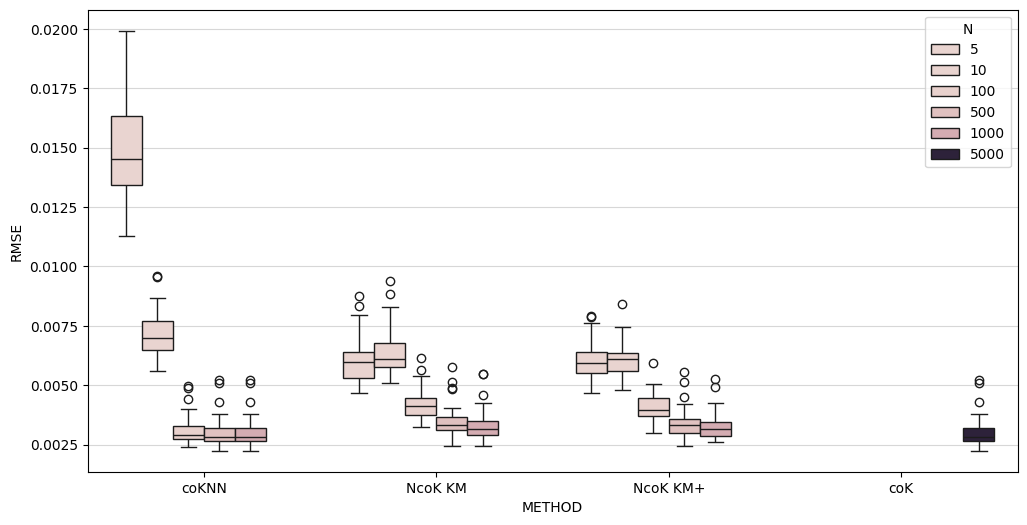

In [34]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='METHOD', y='RMSE', hue='N')
plt.grid(axis='y', alpha=0.5, zorder=1);

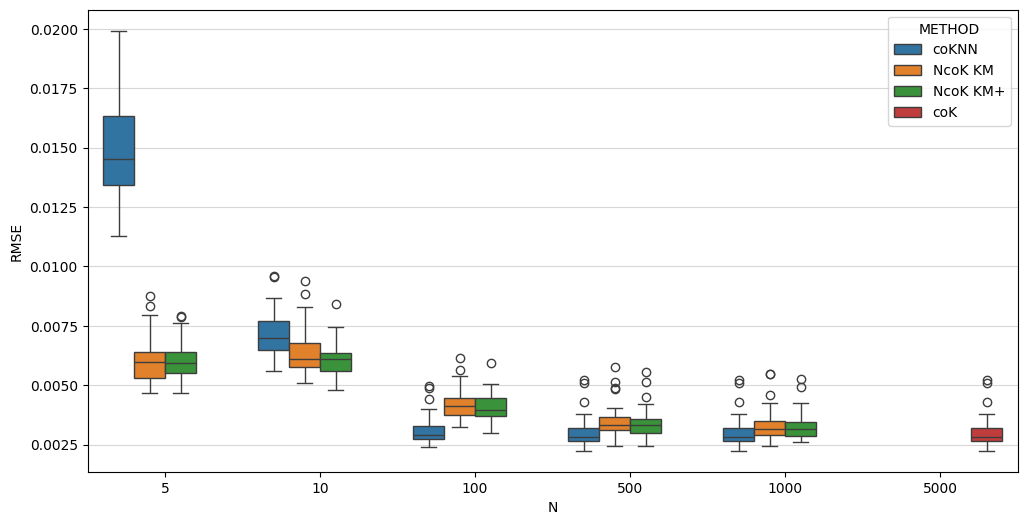

In [35]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='N', y='RMSE', hue='METHOD')
plt.grid(axis='y', alpha=0.5, zorder=1);

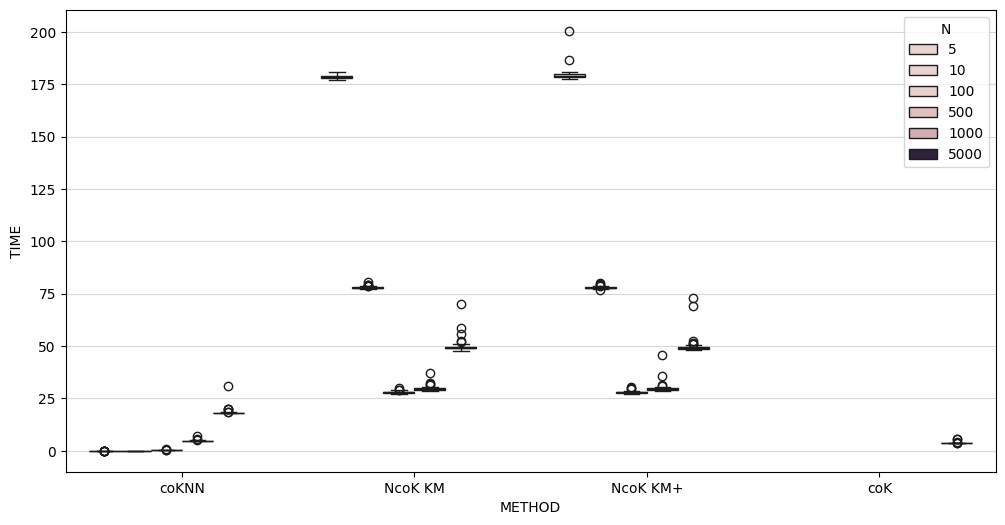

In [36]:
plt.figure(figsize=(12,6))
sns.boxplot(data=aux, x='METHOD', y='TIME', hue='N')
plt.grid(axis='y', alpha=0.5, zorder=1);

In [37]:
data = pd.read_csv('results_experiments_d_3.csv', sep=';')
data.head()

,METHOD,N,K,TIME,RMSE,n,nu_1,nu_2,theta_1,theta_2
0,coKNN,1000,5,30.082545,0.331394,NaN,NaN,NaN,NaN,NaN
1,NcoK KM,1000,5,141.780833,0.336332,NaN,NaN,NaN,NaN,NaN
2,NcoK KM+,1000,5,49.674062,0.329246,NaN,NaN,NaN,NaN,NaN
3,coKNN,500,10,3.845571,0.331375,NaN,NaN,NaN,NaN,NaN
4,NcoK KM,500,10,28.882469,0.334277,NaN,NaN,NaN,NaN,NaN


In [38]:
data = pd.concat([data, aux], axis=0)

In [39]:
data.to_csv('results_experiments_d_3.csv', index=False, sep=';')